## BERT embeddings of news topics + LSTM

**`Exchange rates and stock prices`** move randomly, and that makes it too hard to predict them with ordinary time-series prediction models. In orger to achive high accuracy in prediction, a number of study has been performed. Some of the studies show there is **a strong relationship between exchange rates & stock prices and news articles**. This comes from a obvious idea that they have to do with the state of the country and the world. Therefore, using news articles as features can be expected to improve prediction accuracy, and this effect has been confirmed in practice.

**`BERT`**(Bidirectional Encoder Representations from Transformers) is the state-of-the-art NLP(Natural Language Processing) model as of 2018. One of the features of BERT is that BERT is now able to "read context" by learning from both sides of a sentence (sentence starters and enders) with its built-in architecture called Transformer. Among all its uses of BERT, it is also used as **a vectorization of sentences due to its superior performance**. That information holds so much better text representation than conventional methods that the accuracy in many NLP domains was improved.

### Target

Here, considering the above, set up a hypothesis,   

#### **"Can the features embeddings by BERT improve an accuracy of the exchange rate prediction??"**

In this notebook, Let's see how BERT text embeddings performs well in predicting exchange rate.

### Library

※ Specify the GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [53]:
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [79]:
import random
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
import lightgbm as lgb

import gc
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [6]:
save_dir = "bert_embeddings"
os.makedirs(save_dir, exist_ok=True)

### Data

[Daily News for Stock Market Prediction](https://www.kaggle.com/aaron7sun/stocknews) has both **News data** including historical news headlines from Reddit WorldNews Channel and  **Stock data** (Dow Jones Industrial Average (DJIA)).  
This dataset is suitable for this experimentation and help us to save time of crawling news headlines.

<br>

#### Short summary of Description in [kaggle page](https://www.kaggle.com/aaron7sun/stocknews) is below.

>- **News data**: Historical news headlines from Reddit WorldNews Channel.  
They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date.   
(Range: 2008-06-08 to 2016-07-01)
> 
>- **Stock data**: Dow Jones Industrial Average (DJIA) is used to "prove the concept". (Range: 2008-08-08 to 2016-07-01)

<br>

#### Data description

>- **RedditNews.csv** : two columns  
The first column is the "date", and second column is the "news headlines".  
All news are ranked from top to bottom based on how hot they are.  
Hence, there are 25 lines for each date.  
>
>- **DJIA_table.csv** :    
Downloaded directly from Yahoo Finance: check out the web page for more info.
>
>- **CombinedNewsDJIA.csv** :  
To make things easier for my students, I provide this combined dataset with 27 columns.  
The first column is "Date", the second is "Label", and the following ones are news headlines ranging from "Top1" to "Top25".  

#### Label description

>- **"1"** :  when DJIA Adj Close value rose or stayed as the same;
>- **"0"** :  when DJIA Adj Close value decreased.

<br>

For task evaluation, please use data from 2008-08-08 to 2014-12-31 as Training Set, and Test Set is then the following two years data (from 2015-01-02 to 2016-07-01). This is roughly a 80%/20% split.

<br>

**Reference**  
- Sun, J. (2016, August). Daily News for Stock Market Prediction, Version 1. Retrieved [Date You Retrieved This Data] from https://www.kaggle.com/aaron7sun/stocknews.

**Kaggle notebook References**  
- [Stock Price Prediction - 94% XGBoost](https://www.kaggle.com/shreyams/stock-price-prediction-94-xgboost)
- [OMG! NLP with the DJIA and Reddit!](https://www.kaggle.com/ndrewgele/omg-nlp-with-the-djia-and-reddit)
- [Use News to predict Stock Markets](https://www.kaggle.com/lseiyjg/use-news-to-predict-stock-markets)

#### get data

In [3]:
sentence_file = "Combined_News_DJIA.csv"
sentence_df = pd.read_csv(sentence_file, parse_dates=[0])

stock_prices = "upload_DJIA_table.csv"
stock_data = pd.read_csv(stock_prices, parse_dates=[0])

merged_dataframe = sentence_df[['Date', 'Label']].merge(stock_data, how='inner', on='Date', left_index=True)
merged_dataframe["Volume"] = merged_dataframe["Volume"].astype(float)

In [ ]:
for c in stock_data.columns[1:]:
    stock_data.plot('Date', c, figsize=(25,5), linewidth=1)#, title=c)
    plt.title(c)
    plt.show()

### BERT embeddings

Features : **original feature + `BERT embedded feature`**

BERT embeds a text into 1536-dimensional representation, and this high dimentinal info is hard to handle. Therefore, in this experiment, narrow down the top 25 news articles to the top 10.

In [10]:
df_bert = sentence_df.merge(stock_data, how='inner', on='Date', left_index=True)
df_bert.index = df_bert["Date"]
df_bert.drop("Date",axis=1,inplace=True)

# narrow down the news articles to the top 10.
df_bert = df_bert.drop(df_bert.columns[11:26],axis=1)

# remove unnecessary characters
df_bert = df_bert.replace('b\"|b\'|\\\\|\\\"', '', regex=True)

#### keras-bert

Keras implementation of the BERT is availabel at "keras-bert".  
Official pre-trained models could be loaded for feature extraction and prediction.

**install**
```bash
pip install keras-bert
```

#### output where keras-bert model is.

In [1]:
import keras_bert
from keras_bert import get_pretrained, PretrainedList, get_checkpoint_paths

model_path = get_pretrained(PretrainedList.multi_cased_base)
paths = get_checkpoint_paths(model_path)
print(paths.config, paths.checkpoint, paths.vocab)

# ->
# /home/yourhome/.keras/datasets/multi_cased_L-12_H-768_A-12/bert_config.json
# /home/yourhome/.keras/datasets/multi_cased_L-12_H-768_A-12/bert_model.ckpt
# /home/yourhome/.keras/datasets/multi_cased_L-12_H-768_A-12/vocab.txt

In [1]:
# change "yourname" based on above outputs
model_path = '/home/yourhome/.keras/datasets/multi_cased_L-12_H-768_A-12'

#### get BERT embeddings

In [8]:
from keras_bert import extract_embeddings, POOL_NSP, POOL_MAX

embeddings_arr = []
for i in tqdm(range(1,10+1)):
    embeddings = extract_embeddings(model_path, df_bert.iloc[:,i], poolings=[POOL_NSP, POOL_MAX])
    embeddings_arr.append(np.array(embeddings))

    # to avoid out of memory
    K.clear_session()
    gc.collect()
embeddings_arr = np.array(embeddings_arr)

100%|██████████| 10/10 [10:57<00:00, 65.79s/it]


In [11]:
# save BERT_Embeddings
np.save(save_dir+'/BERT_Embeddings', embeddings_arr)

#### PCA bert-embeddings compression

In [19]:
# train test split
n_train = 1611
e_train,e_test = embeddings_arr[:,:n_train],embeddings_arr[:,n_train:]

e_train.shape,e_test.shape

((10, 1611, 1536), (10, 378, 1536))

In [27]:
e_dim = 1536 # dimention of bert-embeddings

from sklearn.decomposition import PCA
n_components=3
pca = PCA(n_components=n_components)
pca.fit(e_train.reshape((-1,e_dim)))

# get compressed bert-embeddings
e_train_pca = pca.transform(e_train.reshape((-1,e_dim)))
e_test_pca = pca.transform(e_test.reshape((-1,e_dim)))

e_train_pca = e_train_pca.reshape((10,-1,n_components))
e_test_pca = e_test_pca.reshape((10,-1,n_components))

np.save(save_dir+'/BERT_Embeddings_pca_train', e_train_pca)
np.save(save_dir+'/BERT_Embeddings_pca_test', e_test_pca)

e_train_pca.shape,e_test_pca.shape

((10, 1611, 3), (10, 378, 3))

In [14]:
e_train_pca = np.load(save_dir+'/BERT_Embeddings_pca_train.npy')
e_test_pca = np.load(save_dir+'/BERT_Embeddings_pca_test.npy')

#### reshape data for table data

In [15]:
X_e_train = e_train_pca.transpose((1,0,2))
X_e_train = X_e_train.reshape((len(X_e_train),-1))

X_e_test = e_test_pca.transpose((1,0,2))
X_e_test = X_e_test.reshape((len(X_e_test),-1))

X_e_train.shape,X_e_test.shape

((1611, 30), (378, 30))

In [19]:
df_embeddings = pd.DataFrame(np.concatenate([X_e_train,X_e_test]))
df_embeddings.columns = [f"{y+1}_{x+1}" for y in range(10) for x in range(3)]
df_embeddings.index = df_bert.index

#### complete data

In [20]:
# save table data
df_BERT = pd.concat([df_bert, df_embeddings], axis=1)
df_BERT.to_csv(save_dir+'/df_bert_embeddings.csv',index=True)

In [22]:
# load table data
df_BERT = pd.read_csv(save_dir+'/df_bert_embeddings.csv',index_col=0)

### Prediction & Evaluation

In [40]:
result_dir = "results"
os.makedirs(result_dir)

#### Data Preprocess

In [32]:
from sklearn.preprocessing import MinMaxScaler

def remove_str(df):
    """ Remove News Topics (string type )
    """
    
    try:
        remove_cols = [f"Top{i}" for i in range(1,11)]
        df = df.drop(remove_cols,axis=1)        
    except:
        pass
    
    return df


def make_train_test(df):
    """ Train Test split by date.
    """
    
    df_train = df[df.index < '2015-01-01']
    df_test = df[df.index >= '2015-01-01']
    
    return df_train,df_test


def reshape_data(X_train,X_test,timesteps=10):
    """ Reshape data for time-series model input.
    """
    
    n_feature = len(X_train.columns) # ラベルを除く
    
    # Standardization
    x_scaler = MinMaxScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)

    X_train = X_train.reshape((-1,timesteps,n_feature))
    X_test = X_test.reshape((-1,timesteps,n_feature))
    
    return X_train,X_test


def prepare_data(df):
    
    df = remove_str(df)
    df_train, df_test = make_train_test(df)

    y_train = df_train["Label"]
    y_test = df_test["Label"]
    df_train.drop(["Label"],axis=1,inplace=True)
    df_test.drop(["Label"],axis=1,inplace=True)
        
    X_train, X_test = reshape_data(df_train, df_test, timesteps=1)
    
    return X_train, X_test, y_train, y_test

#### Model

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,Flatten,Activation, Input
from tensorflow.keras.layers import SimpleRNN,LSTM,GRU,RNN


def get_LSTM_regressor(sequence_len,n_feature):
    
    inputs = Input(shape=(sequence_len,n_feature))
    x = LSTM(64,recurrent_dropout = 0.2, return_sequences=True)(inputs) 
    x = Dropout(0.25)(x)
    x = LSTM(32,recurrent_dropout=0.2)(x)
    outputs = Dense(1,activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model


def get_LSTM_classifier(sequence_len,n_feature):
    """
        # return_sequenceとは、TrueにしてRNNレイヤーの毎時刻の出力を得るか、Falseにして最後の時刻のみの出力を得るか、のフラグのようです。
        # デフォルトではFalseになっていて、最後の時刻のみの出力を得ます。
        # RNNレイヤーを複数積み重ねたい時は、各時刻で層間のデータのやり取りがあるので、(少なくとも最後の層以外は)必ずTrueにしなければならないようです。
    """
    
    inputs = Input(shape=(sequence_len,n_feature))
    x = LSTM(128,recurrent_dropout = 0.2, return_sequences=True)(inputs)
    # x = Dropout(0.25)(x)
    x = LSTM(64,recurrent_dropout=0.2)(x)
    outputs = Dense(2,activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model


def get_LSTM_classifier2(sequence_len,n_feature):
    
    inputs = Input(shape=(sequence_len,n_feature))
    x = LSTM(128,recurrent_dropout=0.0)(inputs)
    outputs = Dense(2,activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

#### Original Data

In [36]:
# prepare data
df_org = merged_dataframe.copy()
df_org = df_org.set_index("Date")

X_train, X_test, y_train, y_test = prepare_data(df_org)

/home/katafuchi/miniconda3/envs/myenv/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


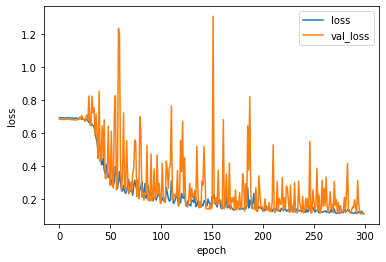

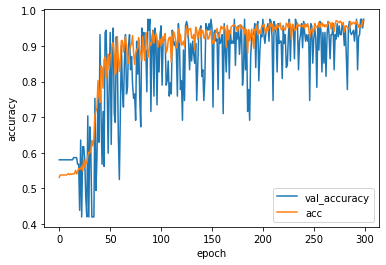

In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(lr=0.001)

model = get_LSTM_classifier(sequence_len=1,n_feature=X_train.shape[-1])
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, mode='auto', epsilon=0.001, min_lr=0.0001)

history = model.fit(
    X_train,
    to_categorical(y_train,2),
    epochs=300,
    validation_split=0.1,
    callbacks=[reduce_lr],
    verbose=0
)

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.savefig(result_dir+"/org_loss.png", dpi=150, bbox_inches=None, pad_inches=0.1)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend() 
plt.savefig(result_dir+"/org_acc.png", dpi=150, bbox_inches=None, pad_inches=0.1)
plt.show()

In [47]:
model.save(result_dir+"/org_LSTM.h5")

In [46]:
# Predict
pred = model.predict(X_test)
pred = np.argmax(pred,axis=-1)

print(f"Acc = {accuracy_score(y_test,pred)} \n")

print("Classification Report")
print(classification_report(y_test,pred))

print("Confuson Matrix")
print(confusion_matrix(y_test,pred))

Acc = 0.9576719576719577 

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       186
           1       0.97      0.95      0.96       192

    accuracy                           0.96       378
   macro avg       0.96      0.96      0.96       378
weighted avg       0.96      0.96      0.96       378

Confuson Matrix ===== 

[[180   6]
 [ 10 182]]


#### BERT embeddings Data

In [48]:
# prepare data
X_train_bert, X_test_bert, y_train, y_test = prepare_data(df_BERT)

/home/katafuchi/miniconda3/envs/myenv/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [122]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(lr=0.001)

# get_LSTM_classifier2 is better than get_LSTM_classifier in this data.
model_bert = get_LSTM_classifier2(sequence_len=1,n_feature=X_train_bert.shape[-1])
model_bert.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=20, mode='auto', epsilon=0.001, min_lr=0.0001)

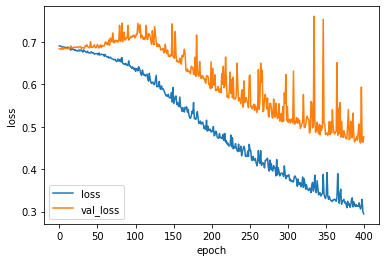

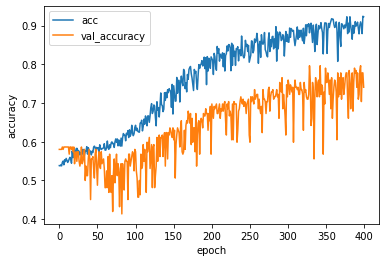

In [123]:
history_bert = model_bert.fit(
    X_train_bert,
    to_categorical(y_train,2),
    epochs=400,
    validation_split=0.1,
    callbacks=[reduce_lr],
    verbose=0
)
plt.figure()
plt.plot(history_bert.history['loss'], label='loss')
plt.plot(history_bert.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.savefig(result_dir+"/bert_loss.png", dpi=150, bbox_inches=None, pad_inches=0.1)
plt.show()

plt.figure()
plt.plot(history_bert.history['accuracy'], label='acc')
plt.plot(history_bert.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend() 
plt.savefig(result_dir+"/bert_acc.png", dpi=150, bbox_inches=None, pad_inches=0.1)
plt.show()

In [47]:
# model.save(result_dir+"/org_LSTM.h5")

In [125]:
# Predict
pred = model_bert.predict(X_test_bert)
pred = np.argmax(pred,axis=-1)

print(f"Acc = {accuracy_score(y_test,pred)} \n")

print("Classification Report")
print(classification_report(y_test,pred))

print("Confuson Matrix")
print(confusion_matrix(y_test,pred))

Acc = 0.8809523809523809 

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       186
           1       0.88      0.89      0.88       192

    accuracy                           0.88       378
   macro avg       0.88      0.88      0.88       378
weighted avg       0.88      0.88      0.88       378

Confuson Matrix
[[163  23]
 [ 22 170]]


#### BERT embeddings Data (Top 1 news)

In [114]:
# prepare data
X_train_bert_top3, X_test_bert_top3, y_train, y_test = prepare_data(df_BERT)
X_train_bert_top3, X_test_bert_top3 = X_train_bert_top3[...,:-27], X_test_bert_top3[...,:-27]

/home/katafuchi/miniconda3/envs/myenv/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [115]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(lr=0.001)

model_bert = get_LSTM_classifier(sequence_len=1,n_feature=X_train_bert_top3.shape[-1])
model_bert.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=20, mode='auto', epsilon=0.001, min_lr=0.0001)

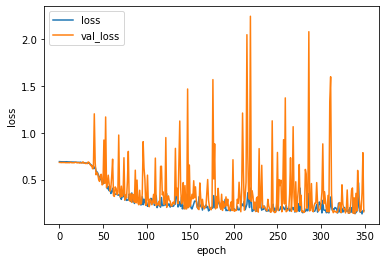

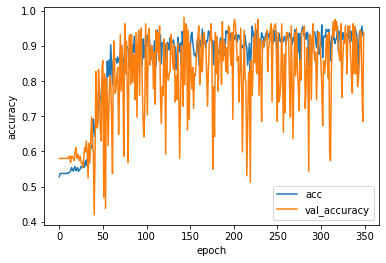

In [116]:
history_bert_top3 = model_bert.fit(
    X_train_bert_top3,
    to_categorical(y_train,2),
    epochs=350,
    validation_split=0.1,
    callbacks=[reduce_lr],
    verbose=0
)
plt.figure()
plt.plot(history_bert_top3.history['loss'], label='loss')
plt.plot(history_bert_top3.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.savefig(result_dir+"/bert_loss_top3.png", dpi=150, bbox_inches=None, pad_inches=0.1)
plt.show()

plt.figure()
plt.plot(history_bert_top3.history['accuracy'], label='acc')
plt.plot(history_bert_top3.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend() 
plt.savefig(result_dir+"/bert_acc_top3.png", dpi=150, bbox_inches=None, pad_inches=0.1)
plt.show()

In [119]:
model_bert.save(result_dir+"/bert_LSTM_top1.h5")

In [118]:
# Predict
pred = model_bert.predict(X_test_bert_top3)
pred = np.argmax(pred,axis=-1)

print(f"Acc = {accuracy_score(y_test,pred)} \n")

print("Classification Report")
print(classification_report(y_test,pred))

print("Confuson Matrix")
print(confusion_matrix(y_test,pred))

Acc = 0.9444444444444444 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       186
           1       0.93      0.97      0.95       192

    accuracy                           0.94       378
   macro avg       0.95      0.94      0.94       378
weighted avg       0.95      0.94      0.94       378

Confuson Matrix
[[171  15]
 [  6 186]]


---
hidden references etc

<!--
* [為替（ドル円レート）を機械学習で予測するモデルの実装 - Qiita](https://qiita.com/merry1221/items/ae66a166b86fd1bd8aca)
* [LSTMでFX予測をやってみよう（機械学習初心者向けチュートリアル）](http://www.algo-fx-blog.com/lstm-fx-predict/)
* [【Python】QRNNでカオス時系列データ予測【Keras】 - Qiita](https://qiita.com/yukiB/items/681f68690ffabbf3e1e1)
* [jupyter notebook上で金融データの描画・取得・操作 - Qiita](https://qiita.com/u1and0/items/6bc0dbeed0e20dd89eda)
* [NLC2016-Ichinose.pdf](http://www.pluto.ai.kyutech.ac.jp/~shimada/paper/NLC2016-Ichinose.pdf)
* [en](https://www.jstage.jst.go.jp/article/jasmin/2018t06/0/2018t06_28/_pdf/-char/en)
* [【Python】TA-LIBを使って移動平均線を引く | たぬきねこのAI＆FX研究室](https://www.tcom242242.net/entry/fx-begin/%E3%83%86%E3%82%AF%E3%83%8B%E3%82%AB%E3%83%AB%E5%88%86%E6%9E%90/fx-moving-ave/)
* [【Python】テクニカル指標が簡単に計算できるTa-libの使い方 | ミナピピンの研究室](https://tkstock.site/2018/08/22/post-593/)
* [TA-Libでテクニカル分析 - Qiita](https://qiita.com/ryoshi81/items/983c06e0bf859b280eba)

---

* [TensorFlow (ディープラーニング)で為替(FX)の予測をしてみる - Qiita](https://qiita.com/hayatoy/items/b9ddf4d6d8e026dc15e5)
* [為替をDeepLearningで予測してみた話 - Qiita](https://qiita.com/ognek/items/1b776d504d20bd6f6d7d)
* [DeepLearningとSpectrogramを用いた為替予測手法の検討 - Qiita](https://qiita.com/Yu-Nie/items/0d80bae73b52877fd15d)
* [TensorFlow (ディープラーニング)で為替(FX)の予測をしてみる CNN編 - Qiita](https://qiita.com/hayatoy/items/0ec3f3da680ae192ddc7)
* [Deep LearningでBitcoinの価格予測をやってみる - Qiita](https://qiita.com/jumbOrNot/items/5b213ebba290b68b1e52)
* [PythonでWebスクレイピングしてみたのでメモ - Qiita](https://qiita.com/merito/items/a0217437b6aabd5ecb3e)
* [機械学習で為替予測(FX)をしてみる](https://www.acceluniverse.com/blog/developers/2020/08/machine-learning-fx.html)
* [TCNを用いてFX予測してみる | GMOインターネット 次世代システム研究室](https://recruit.gmo.jp/engineer/jisedai/blog/fx_price_prediction_using_temporal_convolutional_network/)
* [【機械学習】LSTMを使ってFX予測を行ってみた【未来予測】 | Aidemy Premium](https://premium.aidemy.net/magazine/entry/2019/02/02/182210)
* [為替の予測をやってみた(その1〜データ取得編〜) - MorinoKuma3’s Tech Blog](https://morinokuma3.hatenablog.com/entry/2019/04/07/210031)
* [【Python,FX】単純なディープラーニングで為替を予想する | たぬきねこのAI＆FX研究室](https://www.tcom242242.net/entry/fx-begin/%E3%80%90fx-ai%E3%80%91%E5%8D%98%E7%B4%94%E3%81%AA%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%A7%E7%82%BA%E6%9B%BF%E3%82%92%E4%BA%88%E6%83%B3%E3%81%99/)
* [【10個掲載】機械学習による株価予測のデータセットまとめ | Lionbridge AI](https://lionbridge.ai/ja/datasets/stock-market-prediction-datasets/)
* [機械学習で為替予測 Deep Learning 編 | kuune.org](https://kuune.org/text/2017/04/09/market-prediction-with-deep-learning/)
* [機械学習と時系列予測 – 株式会社東急総合研究所](https://www.triinc.co.jp/researcher_column/%E3%80%8C%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%A8%E6%99%82%E7%B3%BB%E5%88%97%E4%BA%88%E6%B8%AC%E3%80%8D/)
* [0.1秒後の為替レートを8～9割の精度で予測!ＡＩによる金融市場研究はどこまで進んだ？｜2ページ目｜ドル・円・ユーロの明日はどっちだ!? - ザイFX！](https://zai.diamond.jp/articles/-/319692?page=2)
* [img_b8c4ff48329925e3df0a4b5404a3fff5247230.jpg (1000×559)](https://zai.diamond.jp/mwimgs/b/8/-/img_b8c4ff48329925e3df0a4b5404a3fff5247230.jpg)
* [「日経平均」ってなんですか？｜はじめての株式投資(入門)｜松井証券](https://www.matsui.co.jp/service/stock/study/qa/qa_04.html)
* [為替相場が変動するしくみを知ろう！ | わかっておきたい投資のこと | man@bowまなぼう](https://manabow.com/foreign/chapter3/1.html#:~:text=%E5%9B%BD%E5%A2%83%E3%82%92%E8%B6%8A%E3%81%88%E3%81%9F%E6%8A%95%E8%B3%87,%E5%A4%89%E5%8B%95%E3%81%AE%E6%9C%80%E5%A4%A7%E3%81%AE%E8%A6%81%E5%9B%A0&text=%E3%82%82%E3%81%97%E3%80%81%E6%97%A5%E6%9C%AC%E3%81%AE%E9%87%91%E5%88%A9%E3%81%8C,%E3%82%92%E5%B0%8E%E3%81%8F%E3%81%A8%E8%80%83%E3%81%88%E3%82%89%E3%82%8C%E3%82%8B%E3%80%82)
* [日経平均株価と為替レートの相関関係](http://www.777money.com/tameru/nikkei_dolyen.html)

-->